# Trénovanie modelu iba na základe DST indexu 3h dopredu 6 dozadu
Súbor: 6_dopredu_3_dozadu.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Import knižníc

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'DST+3']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+3'

y_col='DST+3'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()
y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [3]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [5]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-02-27 23:12:30.314261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6674 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [6]:
# callbacks
saved_model = "6_dozadu_3_dopredu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [7]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-02-27 23:12:37.847244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1139/1139 [==============================] - ETA: 0s - loss: 94.9193 - mae: 3.0785
Epoch 1: val_mae improved from inf to 2.32055, saving model to 6_dozadu_3_dopredu.hdf5
1139/1139 [==============================] - 76s 60ms/step - loss: 94.9193 - mae: 3.0785 - val_loss: 46.8037 - val_mae: 2.3205
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 19.2019 - mae: 1.7359
Epoch 2: val_mae improved from 2.32055 to 1.94607, saving model to 6_dozadu_3_dopredu.hdf5
1139/1139 [==============================] - 68s 60ms/step - loss: 19.2019 - mae: 1.7359 - val_loss: 25.0248 - val_mae: 1.9461
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 10.7226 - mae: 1.4131
Epoch 3: val_mae did not improve from 1.94607
1139/1139 [==============================] - 69s 60ms/step - loss: 10.7226 - mae: 1.4131 - val_loss: 18.3978 - val_mae: 2.0030
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 8.3689 - mae: 1.2426
Epoch 4: val_mae did not improv

In [8]:
# load best model
model = keras.models.load_model('6_dozadu_3_dopredu.hdf5')

In [9]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 9s 14ms/step


In [10]:
y_pred

array([[ 13.545143 ],
       [ 13.589531 ],
       [ 13.3562155],
       ...,
       [-23.445581 ],
       [-25.856146 ],
       [-27.68639  ]], dtype=float32)

In [11]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124631      6]
 [  6074  24542]]


In [12]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    124637
           1       1.00      0.80      0.89     30616

    accuracy                           0.96    155253
   macro avg       0.98      0.90      0.93    155253
weighted avg       0.96      0.96      0.96    155253



In [13]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [14]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,14.0,13.545143
7,2004-07-22 05:00:00,14.0,13.589531
8,2004-07-22 06:00:00,14.0,13.356215
9,2004-07-22 07:00:00,11.0,10.947924
10,2004-07-22 08:00:00,11.0,10.745261
...,...,...,...
155254,2022-04-28 20:00:00,-18.0,-16.482697
155255,2022-04-28 21:00:00,-23.0,-20.801706
155256,2022-04-28 22:00:00,-26.0,-23.445581
155257,2022-04-28 23:00:00,-29.0,-25.856146


In [15]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.817176,-8.948048
std,16.339982,14.868941
min,-374.000000,-277.650818
25%,-16.000000,-15.327552
50%,-7.000000,-6.918116
75%,0.000000,0.154142
max,77.000000,67.313927


<AxesSubplot: >

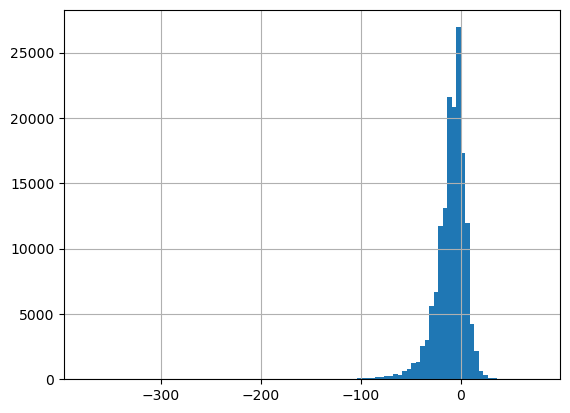

In [16]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

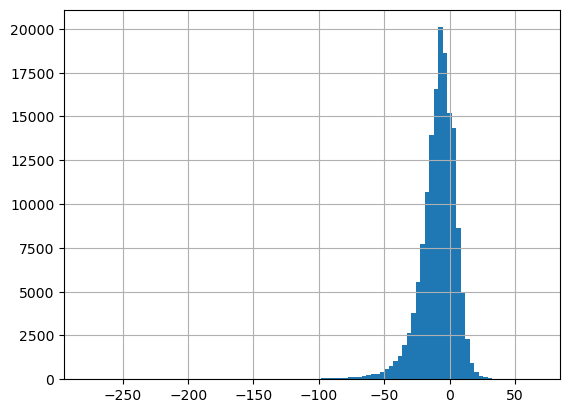

In [17]:
df["y_predict"].hist(bins=100)

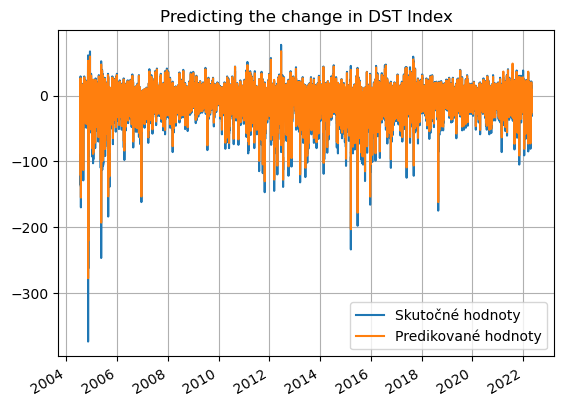

In [18]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [19]:
df.to_csv('predikcie_6h_dozadu_3h_dopredu.csv')

In [20]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

124631
6
6074
24542
TPR=0.8016070028743141
TNR=0.9999518602020266
PPV=0.9997555809027212
NPV=0.9535289392142611
FPR=4.81397979733145e-05
FNR=0.19839299712568592
FDR=0.00024441909727880074
ACC=0.9608381158496132
MCC=0.8741359483131004
